In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns



In [2]:
df = pd.read_csv("https://docs.google.com/spreadsheets/d/e/2PACX-1vQBFaIz7UtP909w7G_3q39Sf4qt0jA43ITVpq5k4fj6XXcMb33iVsNBmtCcZKFR0tlkNTAmj-PxYvIW/pub?gid=1850991007&single=true&output=csv")

In [39]:
df

,bracket,round,trial,budget,sample_type,config_batch_size,config_optimizer,config_momentum,config_hidden_size,config_scheduler_p,config_lerning_rate,config_activation,config_weight_decay,sample_loss,sample_acc
0,5,0,0,1,random,8,rms,0.923345,32,False,0.000676,tanh,0.000000,2.076738,0.2266
1,5,0,1,1,random,32,rms,0.741467,64,True,0.007759,relu,0.000245,2.194144,0.1328
2,5,0,2,1,random,16,rms,0.497789,64,False,0.005600,tanh,0.000518,2.393127,0.1172
3,5,0,3,1,random,16,adam,0.000000,32,False,0.039271,relu,0.000000,2.211292,0.1562
4,5,0,4,1,random,16,adam,0.000000,16,True,0.003812,relu,0.000278,2.015418,0.2422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
569,0,0,1,300,random,32,adam,0.000000,16,False,0.000671,lrelu,0.000633,0.953760,0.8828
570,0,0,2,300,random,8,rms,0.490418,64,True,0.001063,tanh,0.000000,0.537153,0.8906
571,0,0,3,300,random,16,sgd,0.362714,32,True,0.004419,relu,0.000000,1.571169,0.3984
572,0,0,4,300,random,8,adam,0.000000,16,False,0.071858,lrelu,0.000000,1298.374268,0.8594


In [4]:
from sklearn.feature_extraction.text import CountVectorizer

In [29]:
# As the process will be the same all the time, we will create a function
def create_one_hot_vect(data, column):
    non_string_columns = ['bracket', 'round', 'embarked', 'pclass', 'parch', 'boat']
    
    if(column in non_string_columns):
        print("hi")
        data[column] =data[column].apply(lambda x: np.str_(x))
        
    col = set(data[column].values)

    vectorizer = CountVectorizer(vocabulary=list(col), lowercase=False, binary=True)
    vectorizer.fit(data[column].values)

    col_one_hot = vectorizer.transform(data[column].values)
    return col_one_hot

In [30]:
config_optimizer_one_hot = create_one_hot_vect(df, 'config_optimizer')
sample_type_one_hot = create_one_hot_vect(df, 'sample_type')
# config_scheduler_p_one_hot = create_one_hot_vect(df, 'config_scheduler_p')
config_activation_one_hot = create_one_hot_vect(df, 'config_activation')
bracket_one_hot = create_one_hot_vect(df, 'bracket')
round_one_hot = create_one_hot_vect(df, 'round')
config_optimizer_one_hot

hi
hi


<574x3 sparse matrix of type '<class 'numpy.int64'>'
	with 574 stored elements in Compressed Sparse Row format>

In [31]:
from sklearn.preprocessing import StandardScaler

def create_standardized(df, col):
    scalar = StandardScaler()
    scalar.fit(df[col].values.reshape(-1,1)) # finding the mean and standard deviation of this data
# print(f"Mean : {age_scalar.mean_[0]}, Standard deviation : {np.sqrt(age_scalar.var_[0])}")

# Now standardize the data with above mean and variance.
    standardized = scalar.transform(df[col].values.reshape(-1, 1))
    return standardized
budget = create_standardized(df, 'budget')
config_batch_size= create_standardized(df, 'config_batch_size')
config_hidden_size = create_standardized(df, 'config_hidden_size')
config_lerning_rate= create_standardized(df, 'config_lerning_rate')
config_weight_decay=create_standardized(df, 'config_weight_decay')
sample_loss=create_standardized(df, 'sample_loss')
sample_acc=create_standardized(df, 'sample_acc')
# create_standardized(df, 'sample_loss')

In [32]:
from scipy.sparse import hstack
from sklearn.manifold import TSNE

In [33]:
data_matrix = hstack((budget, config_batch_size,
                             config_hidden_size, config_lerning_rate, config_weight_decay,
                             config_optimizer_one_hot,
                             config_activation_one_hot, bracket_one_hot, round_one_hot))

print(data_matrix.shape)

(574, 23)


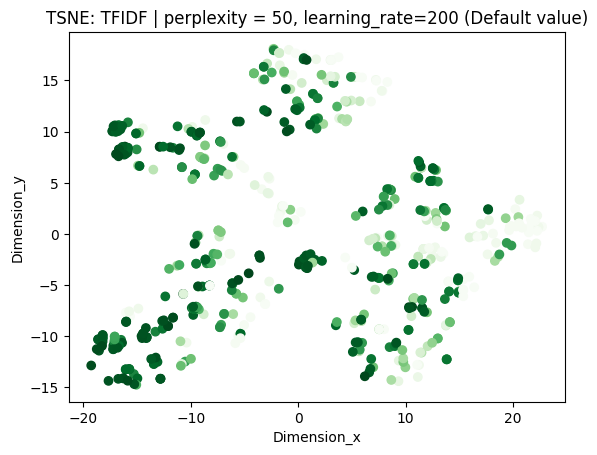

In [34]:
# Convert the matrix into dense matrix
X = data_matrix.toarray()
y = df['sample_acc']
perplexity = 50
tsne = TSNE(n_components=2, random_state=0, perplexity=perplexity)

# Without the expression "np.nan_to_num(X)" we get the below error: 
# ValueError: Input contains NaN, infinity or a value too large for dtype('float32')

X_embedding = tsne.fit_transform(np.nan_to_num(X))
# X_embedding_5 = X_embedding[:336]
# print(len(X_embedding_5))

for_tsne = np.vstack((X_embedding.T, y)).T

for_tsne_df = pd.DataFrame(data=for_tsne, columns=['Dimension_x','Dimension_y','Score'])
# colors = {'random':'red', 'BO':'green', 2:'blue', 3:"yellow", 4:'orange', 5: "purple"}
plt.scatter(for_tsne_df['Dimension_x'], for_tsne_df['Dimension_y'], c=for_tsne_df['Score'], cmap="Greens")
plt.xlabel('Dimension_x')
plt.ylabel('Dimension_y')
plt.title(f'TSNE: TFIDF | perplexity = {perplexity}, learning_rate=200 (Default value)')
plt.show()

In [44]:
X_embedding

array([[ 13.761965 ,  -8.950424 ],
       [ -9.861739 ,  10.460458 ],
       [-11.36568  ,  -3.1337597],
       ...,
       [  1.3291618,  -2.800121 ],
       [  2.2188344,  -2.6343637],
       [  0.9065554,  -3.1146955]], dtype=float32)

In [46]:
df['x'] = X_embedding[:,0]
df['y'] = X_embedding[:,1]
# X_embeddinzxcv1]ㅁㄴㅇㄹㄴㅇㄹ

In [47]:
df.to_csv("add_tsne.csv", index=False)

336


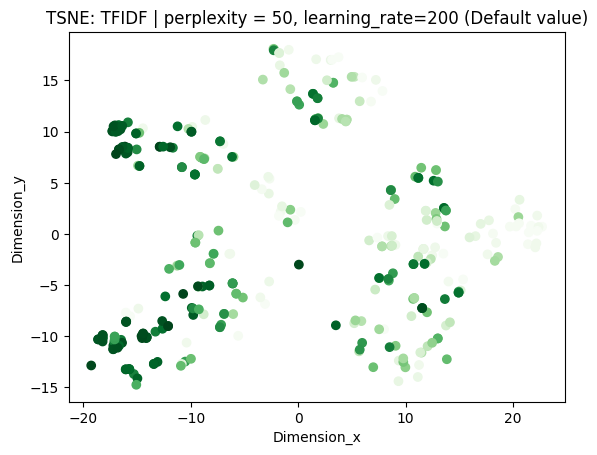

In [35]:
X_embedding = tsne.fit_transform(np.nan_to_num(X))
X_embedding_5 = X_embedding[:336]
print(len(X_embedding_5))

for_tsne = np.vstack((X_embedding_5.T, y[:336])).T

for_tsne_df = pd.DataFrame(data=for_tsne, columns=['Dimension_x','Dimension_y','Score'])
# colors = {'random':'red', 'BO':'green', 2:'blue', 3:"yellow", 4:'orange', 5: "purple"}
plt.scatter(for_tsne_df['Dimension_x'], for_tsne_df['Dimension_y'], c=for_tsne_df['Score'], cmap="Greens")
plt.xlabel('Dimension_x')
plt.ylabel('Dimension_y')
plt.title(f'TSNE: TFIDF | perplexity = {perplexity}, learning_rate=200 (Default value)')
plt.show()

336


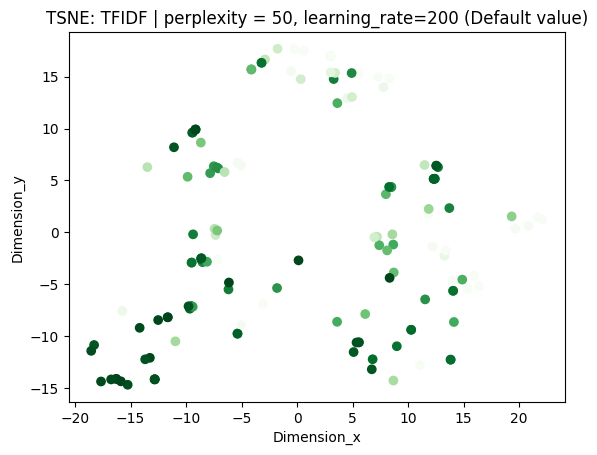

In [25]:
X_embedding_4 = X_embedding[336:473]
print(len(X_embedding_5))

for_tsne = np.vstack((X_embedding_4.T, y[336:473])).T

for_tsne_df = pd.DataFrame(data=for_tsne, columns=['Dimension_x','Dimension_y','Score'])
# colors = {'random':'red', 'BO':'green', 2:'blue', 3:"yellow", 4:'orange', 5: "purple"}
plt.scatter(for_tsne_df['Dimension_x'], for_tsne_df['Dimension_y'], c=for_tsne_df['Score'], cmap="Greens")
plt.xlabel('Dimension_x')
plt.ylabel('Dimension_y')
plt.title(f'TSNE: TFIDF | perplexity = {perplexity}, learning_rate=200 (Default value)')
plt.show()

336


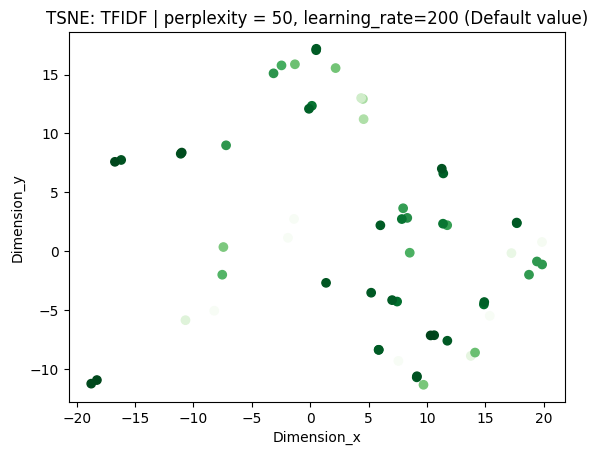

In [26]:
X_embedding_3 = X_embedding[473:531]
print(len(X_embedding_5))

for_tsne = np.vstack((X_embedding_3.T, y[473:531])).T

for_tsne_df = pd.DataFrame(data=for_tsne, columns=['Dimension_x','Dimension_y','Score'])
# colors = {'random':'red', 'BO':'green', 2:'blue', 3:"yellow", 4:'orange', 5: "purple"}
plt.scatter(for_tsne_df['Dimension_x'], for_tsne_df['Dimension_y'], c=for_tsne_df['Score'], cmap="Greens")
plt.xlabel('Dimension_x')
plt.ylabel('Dimension_y')
plt.title(f'TSNE: TFIDF | perplexity = {perplexity}, learning_rate=200 (Default value)')
plt.show()

In [32]:
X_embedding

array([[  8.9134655 ,   0.94659173],
       [ -2.436886  , -13.3781595 ],
       [ -7.867556  ,   0.9906887 ],
       ...,
       [ -8.436224  ,  16.414963  ],
       [ -7.8175344 ,  17.129103  ],
       [ -8.86562   ,  16.004736  ]], dtype=float32)

In [29]:
for_tsne_df

,Dimension_x,Dimension_y,Score
0,8.913465,0.946592,0.2266
1,-2.436886,-13.378160,0.1328
2,-7.867556,0.990689,0.1172
3,10.733079,-5.591934,0.1562
4,12.875634,6.495684,0.2422
...,...,...,...
569,-9.107056,17.348738,0.8828
570,-9.062685,15.732066,0.8906
571,-8.436224,16.414963,0.3984
572,-7.817534,17.129103,0.8594


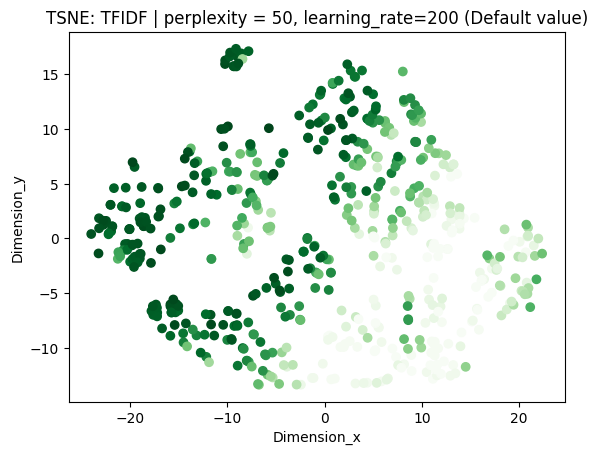